In [1]:
import pandas as pd
import numpy as np
import time
import collections
from tqdm.notebook import tqdm
import copy
import math
import matplotlib.pyplot as plt
import seaborn as sns


import os
os.environ["CUDA_DEVICE_ORDER"] = 'PCI_BUS_ID'
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
!ls $BASE_DIR

args.py        dataset	    README.md	train.ipynb  utils.py
dataloader.py  __pycache__  test.ipynb	train.py


In [3]:
BASE_DIR = './dataset/MapBJ-master/'
radius_Num = 3
p_Num = 5
EPOCHS = 20
BATCH_SIZE = 4096

# 构建数据集
## 获取 Upstream flow and downstream flow neighbor 

In [4]:
graphdata = pd.read_csv(BASE_DIR + "graph.csv")
display(graphdata.sample(5))
downStreamGraph = collections.defaultdict(list)
for i in tqdm(range(len(graphdata))):
    downStreamGraph[ graphdata.iloc[i, 0] ].append( graphdata.iloc[i, 1] )
    
upStreamGraph = collections.defaultdict(list)
for i in tqdm(range(len(graphdata))):
    upStreamGraph[ graphdata.iloc[i, 1] ].append( graphdata.iloc[i, 0] )
    
len(downStreamGraph), len(upStreamGraph)

,source,destination
395,25480,28283
540,28101,27886
625,26853,27869
536,28102,28101
41,21407,22575


  0%|          | 0/731 [00:00<?, ?it/s]

  0%|          | 0/731 [00:00<?, ?it/s]

(332, 327)

构建upstread and downstream

In [5]:

# nums = [[[20915], [22693], [22692]],
#  [[23004, 23080, 27308], [22693], [22692]],
#  [[23744, 23005, 27694, 27778],
#   [23019, 27733, 27311],
#   [22777, 23006, 23217, 27309],
#   [22693],
#   [22692]]]
# import copy
# new_nums = copy.deepcopy( nums )

# for layer in list(range( radius_Num - 1 ))[::-1]:
#     flatL = [x for y in nums[layer] for x in y]
#     newxtLen = [len(x) for x in new_nums[layer+1]]
#     adjFlatl = [[] for y in nums[layer]]
#     flag = 0
#     for idx, v in enumerate( nums[layer] ):
#         for jj in v:
#             adjFlatl[idx].extend( [jj for k in range( newxtLen[flag] )] )
#             flag += 1
#     new_nums[layer] = adjFlatl

# new_nums

# # radius
# AUXradius_downStreamGraph = {}
# radius_downStreamGraph = {}
# for nowp in tqdm(list(downStreamGraph.keys())):
#     AUXradius_downStreamGraph[nowp] = []
#     prevstation = set([nowp])
#     # 第一次
#     AUXradius_downStreamGraph[nowp].append( downStreamGraph[nowp] )
#     prevstation.update( set(downStreamGraph[nowp]) )
#     for layer in range( radius_Num - 1 ):
#         nextNodes = []
#         prevNode = AUXradius_downStreamGraph[nowp][-1]
#         for idx, prevp in enumerate(prevNode):   # 上一层的所有节点
#             tmp_pools = [x for x in downStreamGraph[prevp] if x not in prevstation]  # 不去重会有loop
#             if tmp_pools == []: tmp_pools=[prevp]
# #             tmp_pools = [x for x in downStreamGraph[prevp]] 
#             prevstation.update( set(tmp_pools) )
#             nextNodes.extend( tmp_pools )
#         AUXradius_downStreamGraph[nowp].append( nextNodes )
# AUXradius_downStreamGraph[20916]

In [6]:
# radius
def getRadiusStreamGraph(StreamGraph):
    AUXradius_StreamGraph = {}
    for nowp in tqdm(list(StreamGraph.keys())):
        AUXradius_StreamGraph[nowp] = []
        prevstation = set([nowp])
        # 第一次
        AUXradius_StreamGraph[nowp].append( [[x] for x in StreamGraph[nowp]] )
        prevstation.update( set(StreamGraph[nowp]) )
        for layer in range( radius_Num - 1 ):
            nextNodes = []
            prevNode = AUXradius_StreamGraph[nowp][-1]
            flattenPrevNode = [y for x in prevNode for y in x]
            for idx, prevp in enumerate(flattenPrevNode):   # 上一层的所有节点
                tmp_pools = [x for x in StreamGraph[prevp] if x not in prevstation]  # 不去重会有loop
                if tmp_pools == []: tmp_pools=[prevp]
    #             tmp_pools = [x for x in StreamGraph[prevp]] 
                prevstation.update( set(tmp_pools) )
                nextNodes.append( tmp_pools )

            AUXradius_StreamGraph[nowp].append( nextNodes )

    radius_StreamGraph = {}
    for numsNam in AUXradius_StreamGraph.keys():
        nums = AUXradius_StreamGraph[numsNam]
        new_nums = copy.deepcopy( nums )
        for layer in list(range( radius_Num - 1 ))[::-1]:
            flatL = [x for y in nums[layer] for x in y]
            newxtLen = [len(x) for x in new_nums[layer+1]]
            adjFlatl = [[] for y in nums[layer]]
            flag = 0
            for idx, v in enumerate( nums[layer] ):
                for jj in v:
                    adjFlatl[idx].extend( [jj for k in range( newxtLen[flag] )] )
                    flag += 1
            new_nums[layer] = adjFlatl
        radius_StreamGraph[ numsNam ] = new_nums

    radius_StreamGraph = {k:np.array([[y for xx in k for y in xx] for k in nums]) for k,nums in radius_StreamGraph.items()}
    return radius_StreamGraph

radius_downStreamGraph = getRadiusStreamGraph(downStreamGraph)
radius_upStreamGraph = getRadiusStreamGraph(upStreamGraph)

  0%|          | 0/332 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

In [7]:
radius_downStreamGraph = getRadiusStreamGraph(downStreamGraph)
radius_upStreamGraph = getRadiusStreamGraph(upStreamGraph)

for k, item in radius_downStreamGraph.items():
    if item.shape[1]==0:
        radius_downStreamGraph[k] = radius_upStreamGraph[k]

for k, item in radius_upStreamGraph.items():
    if item.shape[1]==0:
        radius_upStreamGraph[k] = radius_downStreamGraph[k]
    
print(radius_downStreamGraph[28435],"\n\n\n\n" ,radius_upStreamGraph[28435])

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

[[27906 27906 27906 27906]
 [23498 23498 23498 23498]
 [22769 23361 25476 27762]] 



 [[27906 27906 27906 27906]
 [23498 23498 23498 23498]
 [22769 23361 25476 27762]]


/home/lichangyv/miniconda3/envs/torch17/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/lichangyv/miniconda3/envs/torch17/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


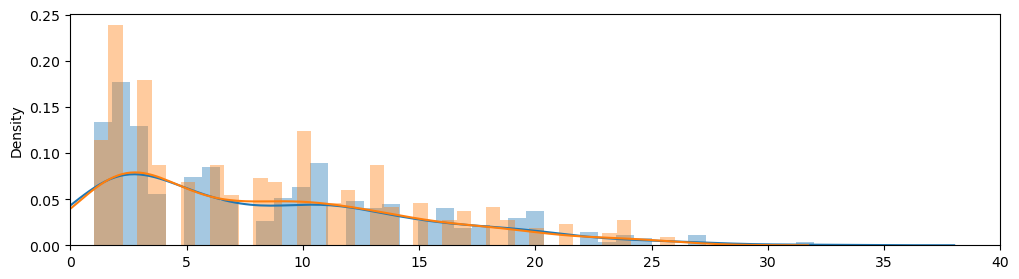

In [8]:
f, ax =plt.subplots(1,1,figsize=(12,3))
sns.distplot([len(v[-1]) for k,v in radius_upStreamGraph.items()], ax=ax, label = "Up", bins=40)
sns.distplot([len(v[-1]) for k,v in radius_downStreamGraph.items()], ax=ax, label = "Down", bins=40)
plt.xlim(0, 40)
plt.show()

## traffic_condition

In [9]:
traffic_condition = pd.read_csv(BASE_DIR + "traffic_condition.csv")
traffic_condition = traffic_condition.sort_values(by='timestamp').reset_index(drop=True)

# traffic_condition['md_timestamp'] = traffic_condition['timestamp'].apply(lambda x: time.strftime("%Y-%m-%d", time.localtime(x)))
# traffic_condition['md_timestamp'] = pd.to_datetime(traffic_condition['md_timestamp'])
# print(traffic_condition['md_timestamp'].drop_duplicates().tolist())

traffic_condition['timestamp'] = traffic_condition['timestamp'].apply(lambda x: time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(x)) )
traffic_condition['timestamp'] = pd.to_datetime(traffic_condition['timestamp'])
                                                                         
traffic_condition = traffic_condition.sort_values(by='timestamp').reset_index(drop=True)
display(traffic_condition)

# traffic_condition['timestamp'].value_counts()

,id,timestamp,condition,limit_level
0,36691,2016-03-01 00:00:00,1,3
1,28545,2016-03-01 00:00:00,1,4
2,23693,2016-03-01 00:00:00,1,3
3,25226,2016-03-01 00:00:00,1,4
4,25476,2016-03-01 00:00:00,1,3
...,...,...,...,...
5711051,28484,2016-06-02 22:55:00,1,3
5711052,27053,2016-06-02 22:55:00,1,4
5711053,28501,2016-06-02 22:55:00,1,4
5711054,28099,2016-06-02 22:55:00,1,4


### 补齐数据

In [10]:
data = []
tmpdata = pd.DataFrame(traffic_condition['timestamp'].drop_duplicates().reset_index(drop=True))
for i in tqdm(traffic_condition['id'].drop_duplicates().tolist()):
#     print(i)
    tmpdata['id'] = i
    data.append( tmpdata.copy(deep=True) )
data = pd.concat(data, axis=0)[['id', 'timestamp']]
traffic_condition = traffic_condition.merge(data, on = ['id','timestamp'], how='right', sort=True)
traffic_condition = traffic_condition.sort_values(by=['id','timestamp']).reset_index(drop=True)

traffic_condition['condition'] = traffic_condition['condition'].fillna(method='pad')
traffic_condition['limit_level'] = traffic_condition['limit_level'].fillna(method='pad')

traffic_condition['NT'] = (traffic_condition['timestamp'].astype(int)/ 100000000000).astype(int)
traffic_condition['timeId'] = traffic_condition['id'].astype(str) + "+" + traffic_condition['NT'].astype(str)
traffic_condition

  0%|          | 0/349 [00:00<?, ?it/s]

,id,timestamp,condition,limit_level,NT,timeId
0,20915,2016-03-01 00:00:00,1.0,4.0,14567904,20915+14567904
1,20915,2016-03-01 00:05:00,1.0,4.0,14567907,20915+14567907
2,20915,2016-03-01 00:10:00,1.0,4.0,14567910,20915+14567910
3,20915,2016-03-01 00:15:00,1.0,4.0,14567913,20915+14567913
4,20915,2016-03-01 00:20:00,1.0,4.0,14567916,20915+14567916
...,...,...,...,...,...,...
5795838,36691,2016-06-02 22:35:00,1.0,3.0,14649069,36691+14649069
5795839,36691,2016-06-02 22:40:00,1.0,3.0,14649072,36691+14649072
5795840,36691,2016-06-02 22:45:00,1.0,3.0,14649075,36691+14649075
5795841,36691,2016-06-02 22:50:00,1.0,3.0,14649078,36691+14649078


In [11]:
train = traffic_condition[traffic_condition['timestamp']<'2016-05-01'].reset_index(drop=True)
test = traffic_condition[traffic_condition['timestamp']>='2016-05-01'].reset_index(drop=True)
train.shape, test.shape

((4412756, 6), (1383087, 6))

In [12]:
def prepareData(df, pnum, ):
    ans = {}         # key: uid+time
    uids = df.id.drop_duplicates().tolist()
    for uid in tqdm(uids):
        tmpudf = df.query(f"id=={uid}").reset_index(drop=True)
        tivF = [tmpudf.loc[0, 'limit_level']]
        for idx in range(len(tmpudf)-1):
            if idx == 0:
                tvO = [tmpudf.loc[0, 'condition']] * pnum
            elif pnum>idx:     # 最开始几个 需要补齐
                prev = tmpudf.loc[:pnum, 'condition'].tolist()
                repeat = pnum // (idx+1) + 1
                tvO = ( tmpudf.loc[:idx, 'condition'].tolist() * repeat )[:pnum]
            elif pnum<=idx:
                tvO = tmpudf.loc[(idx-pnum+1):idx, 'condition'].tolist()
            label = tmpudf.loc[idx+1, 'condition']
            timeuid = tmpudf.loc[idx, 'timeId']
            ans[ timeuid ] = [tvO + tivF, label]  # 这里合并了 self_tvO, self_tivF
    return ans

traindata = prepareData(train, p_Num)
testdata = prepareData(test, p_Num)

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

## dataset 构建

In [18]:
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torch import nn
import torch
 
class MyDataSet(Dataset):
    def __init__(self, data, upgraph, downgraph, rnum, maxlen = 20):
        self.data = data
        self.uidTime = list( self.data.keys() )
        self.upgraph = upgraph
        self.downgraph = downgraph
        self.maxlen = maxlen
        self.rnum = rnum
        
    def __getitem__(self, index):
        
        # target location
        timeuid = self.uidTime[index]
        uid, time = timeuid.split("+")
        uid, time = int(uid), int(time)
        
        self_tvFeats, label = self.data[ timeuid ]
        
        ## upstream module
        ### select
        upSlot = self.upgraph[uid]
        if upSlot.shape[1] >= self.maxlen:
            upUids = upSlot[:, :self.maxlen]
        else:
            repeat = self.maxlen // upSlot.shape[1] + 1
            upUids = np.repeat(upSlot, repeat, axis = 1)[:, :self.maxlen]
        ### broadcast
        upSlots = []
        # for layer in range( self.rnum ):
        for layer in range( self.rnum ):
            upSlots.append( [self.data[f"{uid}+{time}"][0] for uid in upUids[layer]] )

            
        ## downstream module
        downSlot = self.downgraph[uid]
        if downSlot.shape[1] >= self.maxlen:
            downUids = downSlot[:, :self.maxlen]
        else:
            repeat = self.maxlen // downSlot.shape[1] + 1
            downUids = np.repeat(downSlot, repeat, axis = 1)[:, :self.maxlen]
        ### broadcast
        downSlots = []
        # for layer in range( self.rnum ):
        for layer in range( self.rnum ):
            downSlots.append( [self.data[f"{uid}+{time}"][0] for uid in downUids[layer]] )
        
        return np.array(self_tvFeats), np.array(upSlots), np.array(downSlots), label
        
    def __len__(self):
        return len( self.uidTime )
    
traindataset = MyDataSet(traindata, radius_upStreamGraph, radius_downStreamGraph, radius_Num, 40)
# traindataset.__getitem__(5)
trainDataloader = DataLoader(traindataset, batch_size=10, shuffle=True, num_workers=10)
for idx, ( pred, up, down, label ) in tqdm(enumerate( trainDataloader ), total=len(trainDataloader)):
#     pass
    break
up.shape, pred.shape, down.shape, label.shape

  0%|          | 0/441241 [00:00<?, ?it/s]

(torch.Size([10, 3, 40, 6]),
 torch.Size([10, 6]),
 torch.Size([10, 3, 40, 6]),
 torch.Size([10]))

In [19]:
def default_conv(in_channels, out_channels, kernel_size, bias=True):
    return nn.Conv2d(
        in_channels, out_channels, kernel_size,
        padding=(kernel_size//2), bias=bias)

class LinearWithChannel(nn.Module):
    """
    https://github.com/pytorch/pytorch/issues/36591
    """
    def __init__(self, input_size, output_size, channel_size):
        super(LinearWithChannel, self).__init__()
        
        #initialize weights
        self.weight = torch.nn.Parameter(torch.zeros(channel_size, input_size, output_size))
        self.bias = torch.nn.Parameter(torch.zeros(channel_size, 1, output_size))
        
        #change weights to kaiming
        self.reset_parameters(self.weight, self.bias)
        
    def reset_parameters(self, weights, bias):
        
        torch.nn.init.kaiming_uniform_(weights, a=math.sqrt(3))
        fan_in, _ = torch.nn.init._calculate_fan_in_and_fan_out(weights)
        bound = 1 / math.sqrt(fan_in)
        torch.nn.init.uniform_(bias, -bound, bound)
    
    def forward(self, x):
        b, ch, r  = x.size()
        x = x.view(ch, b, r)
        x = torch.bmm(x, self.weight) + self.bias
        return x.view(b, ch, -1)

In [20]:
class streamModule(nn.Module):
    def __init__(self, input_size = 64, output_size = 64, channel_size = 3):
        super(streamModule, self).__init__()  
        self.lstm = nn.LSTM(input_size = 960,hidden_size=32,num_layers=3, \
                                  bias=True,batch_first=True,dropout=0.5,bidirectional=False)
        self.ffn = LinearWithChannel(input_size, output_size, channel_size)
    def forward(self, stream, x):
        stream, _  = self.lstm( stream )          # # 这里直接用最后一层的输出就不需要max pooling了 -> bs, 3, 32
        x = x.unsqueeze(1).repeat(1,3,1)
        stream = torch.cat([stream, x], axis=2)   # bs * 3 * 64
        stream = self.ffn( stream )                 # bs * 3 * 64
        attw = torch.exp(stream) / torch.sum( torch.exp(stream) , axis = 2).unsqueeze(-1)
        attw = torch.softmax(attw, dim = 1)
        return torch.sum(stream * attw, axis=1)
    


class DeepTransport(nn.Module):
    def __init__(self, convChannel=4, convks = 3, r=3, abla=False):
        super(DeepTransport, self).__init__()  
        self.fnn1 = nn.Sequential(nn.Linear(6, 32), nn.ReLU(), nn.Linear(32, 32), nn.ReLU())
        self.conv = nn.Sequential(default_conv(1, convChannel, convks), nn.ReLU())  # bn
        self.r = r
        self.upstream = streamModule()
        self.downstream = streamModule()

        self.outfnn = nn.Sequential(nn.Linear(160, 64), nn.ReLU(), nn.Linear(64, 1))  # do not add normalization
        
        self.abla = abla
        if self.abla:
            self.outfnnABLA = nn.Sequential(nn.Linear(32, 32), nn.ReLU(), nn.Linear(32, 1))  # do not add normalization
        
    def forward(self, up, down, pred, abla=False):
        bs, r, h, w = up.shape
        pred = self.fnn1( pred )     #  [10, 32]                     
        
        if self.abla:
            return self.outfnnABLA(pred)
        else:  # 需要共享conv
            
            up = self.conv( up.view(-1, 1, h, w) )           # bs * r, 4, 40, 6
            up = up.view(bs, r, -1)                         # bs, r, 960
            lstmoutUp = self.upstream( up, pred )

            down = self.conv( down.view(-1, 1, h, w) )           # bs * r, 4, 40, 6
            down = up.view(bs, r, -1)                         # bs, r, 960
            lstmoutDown = self.upstream( down, pred )

    #         print( pred.shape, lstmoutUp.shape, lstmoutDown.shape )  # torch.Size([10, 32]) torch.Size([10, 64]) torch.Size([10, 64])
            out = torch.cat([  pred, lstmoutUp, lstmoutDown  ], axis=-1)
            out = self.outfnn(out)

            return out
        
model = DeepTransport(abla=True)
print(model)
model(  up.float(), down.float(), pred.float(),  )

DeepTransport(
  (fnn1): Sequential(
    (0): Linear(in_features=6, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
  )
  (conv): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (upstream): streamModule(
    (lstm): LSTM(960, 32, num_layers=3, batch_first=True, dropout=0.5)
    (ffn): LinearWithChannel()
  )
  (downstream): streamModule(
    (lstm): LSTM(960, 32, num_layers=3, batch_first=True, dropout=0.5)
    (ffn): LinearWithChannel()
  )
  (outfnn): Sequential(
    (0): Linear(in_features=160, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
  (outfnnABLA): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
)


tensor([[-0.0245],
        [-0.0009],
        [-0.0402],
        [-0.0402],
        [-0.0662],
        [-0.0402],
        [-0.0402],
        [-0.0857],
        [-0.0662],
        [-0.0486]], grad_fn=<AddmmBackward>)

In [21]:
model = DeepTransport(abla=True)
model = model.cuda()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

traindataset = MyDataSet(traindata, radius_upStreamGraph, radius_downStreamGraph, radius_Num, 40)
train_dataloader = DataLoader(traindataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=10)

testdataset = MyDataSet(testdata, radius_upStreamGraph, radius_downStreamGraph, radius_Num, 40)
test_dataloader = DataLoader(testdataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=10)

        
train_all_losses = []
valid_all_losses = []
losses = []
total_y_pred_train = []
total_y_truth_train = []
model.train()

for epoch in range(EPOCHS):
    ############################################### train
    losses = []
    model.train()
    with tqdm(total=len(train_dataloader), leave=True, desc=f"Train at Epoch {epoch} ==>") as pbar:
        for idx, ( pred, up, down, label ) in enumerate( train_dataloader ):
            optimizer.zero_grad()
            up, down, pred, label = up.float(), down.float(), pred.float(), label.unsqueeze(-1).float()
            up, down, pred, label = up.cuda(), down.cuda(), pred.cuda(), label.cuda()
            out = model(  up, down, pred )
#         total_y_pred.append(y_pred.cpu().detach().numpy())
#         total_y_truth.append(labels.cpu().detach().numpy())
            loss = criterion(label, out)
            loss.backward()
            optimizer.step()
            pbar.update(1)
            pbar.set_postfix({'loss' : '{0:1.5f}'.format(loss.item())})
            losses.append(loss.item())
        epoch_loss = np.mean( losses )
        train_all_losses.append(epoch_loss)
        
    ################################################ test
    losses = []
    model.eval()
    with torch.no_grad():
        for idx, ( pred, up, down, label ) in enumerate( test_dataloader ):
            up, down, pred, label = up.float(), down.float(), pred.float(), label.unsqueeze(-1).float()
            up, down, pred, label = up.cuda(), down.cuda(), pred.cuda(), label.cuda()
            out = model(  up, down, pred )
            loss = criterion(label, out)
            losses.append(loss.item())
        epoch_loss = np.mean( losses )
        valid_all_losses.append(epoch_loss)
        
    mess = f"Epoch #{epoch+1}\tTrain Loss: {train_all_losses[-1]:.3f}\tValid Loss: {valid_all_losses[-1]:.3f}\n\n"
    tqdm.write(mess)

Train at Epoch 0 ==>:   0%|          | 0/1078 [00:00<?, ?it/s]

Epoch #1	Train Loss: 0.115	Valid Loss: 0.102




Train at Epoch 1 ==>:   0%|          | 0/1078 [00:00<?, ?it/s]

Epoch #2	Train Loss: 0.095	Valid Loss: 0.101




Train at Epoch 2 ==>:   0%|          | 0/1078 [00:00<?, ?it/s]

Epoch #3	Train Loss: 0.095	Valid Loss: 0.101




Train at Epoch 3 ==>:   0%|          | 0/1078 [00:00<?, ?it/s]

Epoch #4	Train Loss: 0.094	Valid Loss: 0.101




Train at Epoch 4 ==>:   0%|          | 0/1078 [00:00<?, ?it/s]

Epoch #5	Train Loss: 0.094	Valid Loss: 0.101




Train at Epoch 5 ==>:   0%|          | 0/1078 [00:00<?, ?it/s]

Epoch #6	Train Loss: 0.094	Valid Loss: 0.101




Train at Epoch 6 ==>:   0%|          | 0/1078 [00:00<?, ?it/s]

Epoch #7	Train Loss: 0.094	Valid Loss: 0.101




Train at Epoch 7 ==>:   0%|          | 0/1078 [00:00<?, ?it/s]

Epoch #8	Train Loss: 0.094	Valid Loss: 0.101




Train at Epoch 8 ==>:   0%|          | 0/1078 [00:00<?, ?it/s]

Epoch #9	Train Loss: 0.094	Valid Loss: 0.101




Train at Epoch 9 ==>:   0%|          | 0/1078 [00:00<?, ?it/s]

Epoch #10	Train Loss: 0.094	Valid Loss: 0.101




Train at Epoch 10 ==>:   0%|          | 0/1078 [00:00<?, ?it/s]

Epoch #11	Train Loss: 0.094	Valid Loss: 0.101




Train at Epoch 11 ==>:   0%|          | 0/1078 [00:00<?, ?it/s]

Epoch #12	Train Loss: 0.094	Valid Loss: 0.101




Train at Epoch 12 ==>:   0%|          | 0/1078 [00:00<?, ?it/s]

Epoch #13	Train Loss: 0.094	Valid Loss: 0.101




Train at Epoch 13 ==>:   0%|          | 0/1078 [00:00<?, ?it/s]

Epoch #14	Train Loss: 0.094	Valid Loss: 0.101




Train at Epoch 14 ==>:   0%|          | 0/1078 [00:00<?, ?it/s]

Epoch #15	Train Loss: 0.094	Valid Loss: 0.101




Train at Epoch 15 ==>:   0%|          | 0/1078 [00:00<?, ?it/s]

Epoch #16	Train Loss: 0.094	Valid Loss: 0.101




Train at Epoch 16 ==>:   0%|          | 0/1078 [00:00<?, ?it/s]

Epoch #17	Train Loss: 0.094	Valid Loss: 0.101




Train at Epoch 17 ==>:   0%|          | 0/1078 [00:00<?, ?it/s]

Epoch #18	Train Loss: 0.094	Valid Loss: 0.101




Train at Epoch 18 ==>:   0%|          | 0/1078 [00:00<?, ?it/s]

Epoch #19	Train Loss: 0.094	Valid Loss: 0.100




Train at Epoch 19 ==>:   0%|          | 0/1078 [00:00<?, ?it/s]

Epoch #20	Train Loss: 0.094	Valid Loss: 0.100




In [ ]:
model = DeepTransport()
model = model.cuda()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

traindataset = MyDataSet(traindata, radius_upStreamGraph, radius_downStreamGraph, radius_Num, 40)
train_dataloader = DataLoader(traindataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=10)

testdataset = MyDataSet(testdata, radius_upStreamGraph, radius_downStreamGraph, radius_Num, 40)
test_dataloader = DataLoader(testdataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=10)

        
train_all_losses = []
valid_all_losses = []
losses = []
total_y_pred_train = []
total_y_truth_train = []
model.train()

for epoch in range(EPOCHS):
    ############################################### train
    losses = []
    model.train()
    with tqdm(total=len(train_dataloader), leave=True, desc=f"Train at Epoch {epoch} ==>") as pbar:
        for idx, ( pred, up, down, label ) in enumerate( train_dataloader ):
            optimizer.zero_grad()
            up, down, pred, label = up.float(), down.float(), pred.float(), label.unsqueeze(-1).float()
            up, down, pred, label = up.cuda(), down.cuda(), pred.cuda(), label.cuda()
            out = model(  up, down, pred )
#         total_y_pred.append(y_pred.cpu().detach().numpy())
#         total_y_truth.append(labels.cpu().detach().numpy())
            loss = criterion(label, out)
            loss.backward()
            optimizer.step()
            pbar.update(1)
            pbar.set_postfix({'loss' : '{0:1.5f}'.format(loss.item())})
            losses.append(loss.item())
        epoch_loss = np.mean( losses )
        train_all_losses.append(epoch_loss)
        
    ################################################ test
    losses = []
    model.eval()
    with torch.no_grad():
        for idx, ( pred, up, down, label ) in enumerate( test_dataloader ):
            up, down, pred, label = up.float(), down.float(), pred.float(), label.unsqueeze(-1).float()
            up, down, pred, label = up.cuda(), down.cuda(), pred.cuda(), label.cuda()
            out = model(  up, down, pred )
            loss = criterion(label, out)
            losses.append(loss.item())
        epoch_loss = np.mean( losses )
        valid_all_losses.append(epoch_loss)
        
    mess = f"Epoch #{epoch+1}\tTrain Loss: {train_all_losses[-1]:.3f}\tValid Loss: {valid_all_losses[-1]:.3f}\n\n"
    tqdm.write(mess)

Train at Epoch 0 ==>:   0%|          | 0/1078 [00:00<?, ?it/s]

Epoch #1	Train Loss: 0.113	Valid Loss: 0.101




Train at Epoch 1 ==>:   0%|          | 0/1078 [00:00<?, ?it/s]

Epoch #2	Train Loss: 0.094	Valid Loss: 0.101




Train at Epoch 2 ==>:   0%|          | 0/1078 [00:00<?, ?it/s]

Epoch #3	Train Loss: 0.094	Valid Loss: 0.100




Train at Epoch 3 ==>:   0%|          | 0/1078 [00:00<?, ?it/s]

Epoch #4	Train Loss: 0.093	Valid Loss: 0.099




Train at Epoch 4 ==>:   0%|          | 0/1078 [00:00<?, ?it/s]

Epoch #5	Train Loss: 0.093	Valid Loss: 0.100




Train at Epoch 5 ==>:   0%|          | 0/1078 [00:00<?, ?it/s]

Epoch #6	Train Loss: 0.093	Valid Loss: 0.099




Train at Epoch 6 ==>:   0%|          | 0/1078 [00:00<?, ?it/s]

Epoch #7	Train Loss: 0.093	Valid Loss: 0.099




Train at Epoch 7 ==>:   0%|          | 0/1078 [00:00<?, ?it/s]

Epoch #8	Train Loss: 0.092	Valid Loss: 0.099




Train at Epoch 8 ==>:   0%|          | 0/1078 [00:00<?, ?it/s]

Epoch #9	Train Loss: 0.092	Valid Loss: 0.098




Train at Epoch 9 ==>:   0%|          | 0/1078 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch #11	Train Loss: 0.092	Valid Loss: 0.098




Train at Epoch 11 ==>:   0%|          | 0/1078 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch #14	Train Loss: 0.092	Valid Loss: 0.098




Train at Epoch 14 ==>:   0%|          | 0/1078 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch #17	Train Loss: 0.091	Valid Loss: 0.097




Train at Epoch 17 ==>:   0%|          | 0/1078 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
out

In [ ]:
label